In [7]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparapy as sp
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
# %matplotlib ipympl

Define the parameters and geometry for the simulation.

In [8]:
# Define parameters
X = 1
Y = 1
Z = 1
patch_size = 0.5
ir_length_s = 1
sampling_rate = 100
max_order_k = 10
speed_of_sound = 346.18
absorption = 0.8

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = np.array([1.5, 1.5, 1.5])
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = np.array([[1.5, 1.5, 1.5]])

Calculate new fast approach

In [9]:
start = datetime.now()

# create object
radiosity_fast = sp.DRadiosityFast.from_polygon(walls, patch_size)

# create directional scattering data (totally diffuse)
sources = pf.Coordinates(0, 0, 1)
receivers = pf.Coordinates(0, 0, 1)
frequencies = np.array([1000])
data_scattering = pf.FrequencyData(
    np.ones((sources.csize, receivers.csize, frequencies.size)), frequencies)

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)

# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))


d:\dev\sparapy\.conda\Lib\site-packages\pyfar\classes\coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((
C:\Users\fatela\AppData\Local\Temp\ipykernel_21100\4242122517.py:14: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_scattering(


In [10]:
# calculate from factors including directivity and absorption
radiosity_fast.bake_geometry(ff_method="universal",algorithm="order")

radiosity_fast.init_source_energy(source_pos,ff_method="universal",algorithm="order")

In [11]:
radiosity_fast.calculate_energy_exchange(
        receiver_pos=receiver_pos, speed_of_sound=speed_of_sound,
        histogram_time_resolution=1/sampling_rate,
        histogram_length=ir_length_s, ff_method="universal", algorithm="order",
        max_depth=max_order_k )



In [12]:
ir_fast = radiosity_fast.collect_receiver_energy(receiver_pos=receiver_pos,
                                  speed_of_sound=speed_of_sound,
                                   histogram_time_resolution=1/sampling_rate
                                   )

ir_fast = np.sum(radiosity_fast.collect_receiver_energy(receiver_pos=receiver_pos,
                                  speed_of_sound=speed_of_sound,
                                   histogram_time_resolution=1/sampling_rate,
                                    propagation_fx=True
                                   ),axis=1)[0]

reverberation_fast = pf.Signal(ir_fast, sampling_rate=sampling_rate)

print(ir_fast.shape)

# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

(1, 100)
Time elapsed: 0:01:47.938734


Calculate the analytical reference after Kuttruff.

In [50]:

S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT}s')
E_reverb_analytical = 4/A
t = reverberation_fast.times
# Kuttruff Eq 4.7
w_0 = E_reverb_analytical/ V
t_0 = 0.03
# Kuttruff Eq 4.10
reverberation_analytic = w_0 * np.exp(+(
    speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0))
reverberation_analytic = pf.Signal(
    reverberation_analytic, sampling_rate=sampling_rate)

reverberation distance is 1.5347615963921077m
reverberation time is 0.0804211464597267s


Plot comparison

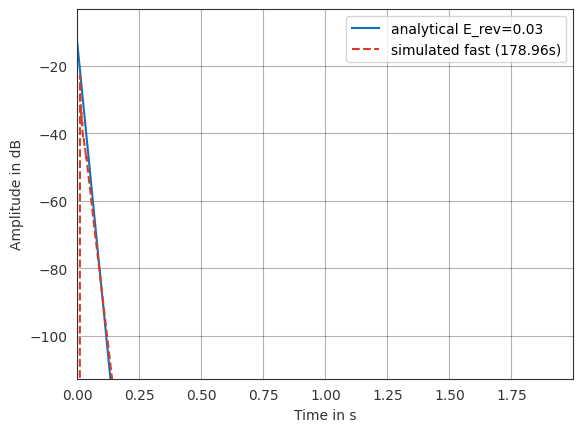

In [51]:
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}')

pf.plot.time(
    reverberation_fast, dB=True, log_prefix=10,
    label=f'simulated fast ({fast_time_s:0.2f}s)',
    linestyle='--')

plt.legend()
plt.show()

In [52]:
%load_ext watermark
%watermark -v -m -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.28.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 5, GenuineIntel
CPU cores   : 16
Architecture: 64bit

pyfar     : 0.6.8
matplotlib: 3.9.2
numpy     : 2.0.2
sparapy   : 0.1.0

